# Monitoreo y Evaluación de Modelos de Detección de Fraude

Este pipeline implementa un sistema de monitoreo y evaluación de rendimiento para un modelo de detección de fraudes. Está diseñado para analizar las predicciones generadas por el modelo y realizar análisis de distribución de características y predicciones. El proceso incluye el cálculo de métricas de rendimiento y la comparación con etiquetas verdaderas.

## Configuración Inicial

1. **Sesión de Spark**: Se crea una sesión de Spark para manejar grandes volúmenes de datos y ejecutar operaciones distribuidas.
2. **Logging**: Configuración de un sistema de logging para rastrear el progreso y capturar posibles errores durante la ejecución.

---

## Rutas de Archivos

### **Archivos de Entrada**
- **Predicciones del modelo**: `/FileStore/tables/scored_transactions_results_batch`
  - Contiene las predicciones generadas por el modelo, con columnas como `transaction_id`, `prob_0`, `prob_1`, y `prediction`.
- **Etiquetas verdaderas procesadas**: `/FileStore/tables/etiquetas_verdaderas_processed`
  - Contiene las etiquetas reales de fraude (`is_fraud`) asociadas con cada `transaction_id`.


In [0]:
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count
import matplotlib.pyplot as plt

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Crear sesión de Spark
def create_spark_session(app_name="Model Monitoring"):
    try:
        spark = SparkSession.builder.appName(app_name).getOrCreate()
        logger.info("Spark session created successfully.")
        return spark
    except Exception as e:
        logger.error(f"Failed to create Spark session: {str(e)}")
        raise


2025-01-21 23:02:13,610 - INFO - Received command c on object id p0


## evaluate_model_performance

### **Propósito:**
Evalúa el rendimiento del modelo de detección de fraudes utilizando la métrica AUC (Área Bajo la Curva).

### **Proceso:**
1. Configura un evaluador binario para medir el rendimiento.
2. Calcula la métrica AUC utilizando las probabilidades predichas y las etiquetas verdaderas.
3. Registra el resultado en los logs.

### **Output:**
- **AUC**: Valor que indica el desempeño del modelo en la clasificación, donde valores cercanos a 1.0 indican un mejor rendimiento.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate_model_performance(predictions, label_col="is_fraud", prob_col="prob_1"):
    try:
        # Usar prob_1 como columna de probabilidades
        evaluator = BinaryClassificationEvaluator(
            labelCol=label_col, 
            rawPredictionCol=prob_col, 
            metricName="areaUnderROC"
        )
        auc = evaluator.evaluate(predictions)
        logger.info(f"Model AUC: {auc:.4f}")
        return auc
    except Exception as e:
        logger.error(f"Error during model evaluation: {str(e)}")
        raise


2025-01-21 23:02:13,739 - INFO - Received command c on object id p0


## feature_distribution_analysis

### **Propósito:**
Analiza la distribución de características clave en el conjunto de datos, calculando estadísticas básicas como media, desviación estándar y recuento.

### **Proceso:**
1. Itera sobre las columnas especificadas como características.
2. Calcula la media, desviación estándar y número de valores para cada característica.
3. Registra los resultados en los logs.

### **Output:**
- Estadísticas de cada característica:
  - **Media**: Valor promedio de la característica.
  - **Desviación estándar**: Variabilidad de los valores de la característica.
  - **Recuento**: Número total de valores de la característica.


In [0]:
def feature_distribution_analysis(df, feature_columns):
    try:
        for feature in feature_columns:
            stats = df.select(
                mean(col(feature)).alias("mean"),
                stddev(col(feature)).alias("stddev"),
                count(col(feature)).alias("count")
            ).collect()[0]

            logger.info(f"Feature: {feature}, Mean: {stats['mean']:.2f}, StdDev: {stats['stddev']:.2f}, Count: {stats['count']}")
    except Exception as e:
        logger.error(f"Error during feature distribution analysis: {str(e)}")
        raise


2025-01-21 23:02:13,833 - INFO - Received command c on object id p0


## prediction_distribution_analysis

### **Propósito:**
Analiza la distribución de las predicciones generadas por el modelo, mostrando la cantidad de predicciones de cada clase y visualizándolas gráficamente.

### **Proceso:**
1. Agrupa las predicciones por clase y calcula el número de ocurrencias para cada clase.
2. Registra los resultados en los logs.
3. Genera un gráfico de barras que muestra la distribución de las predicciones.

### **Output:**
- **Conteo por clase**: Número de predicciones para cada clase (fraude/no fraude).
- **Gráfico de barras**: Representación visual de la distribución de predicciones.


In [0]:
def prediction_distribution_analysis(predictions):
    try:
        prediction_counts = predictions.groupBy("prediction").count().collect()
        for row in prediction_counts:
            logger.info(f"Prediction: {row['prediction']}, Count: {row['count']}")

        # Visualización
        prediction_df = predictions.groupBy("prediction").count().toPandas()
        prediction_df.plot(kind="bar", x="prediction", y="count", title="Prediction Distribution")
        plt.show()
    except Exception as e:
        logger.error(f"Error during prediction distribution analysis: {str(e)}")
        raise


# Ejecución


2025-01-21 23:02:14,058 - INFO - Spark session created successfully.
2025-01-21 23:02:24,519 - INFO - Model AUC: 0.8706
2025-01-21 23:02:24,521 - INFO - Pipeline completed successfully. Model AUC: 0.8706
2025-01-21 23:02:27,459 - INFO - Prediction: 0.0, Count: 56718
2025-01-21 23:02:27,463 - INFO - Prediction: 1.0, Count: 143064


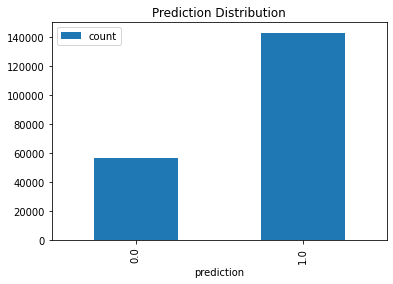

In [0]:
from pyspark.sql.functions import col

def main():
    try:
        # Crear sesión de Spark
        spark = create_spark_session()

        # Cargar las predicciones
        predictions_path = "/FileStore/tables/scored_transactions_results_batch"
        predictions = spark.read.format("csv").option("header", "true").load(predictions_path)

        #predictions.show() 

        # Seleccionar solo las columnas necesarias
        predictions = predictions.select("transaction_id", "prob_1", "prediction")

        # Convertir columnas relevantes a tipo numérico
        predictions = predictions.withColumn("prob_1", col("prob_1").cast("double")) \
                                 .withColumn("prediction", col("prediction").cast("double"))

        # Leer etiquetas verdaderas procesadas
        ground_truth_path = "/FileStore/tables/etiquetas_verdaderas_processed"
        ground_truth = spark.read.format("csv").option("header", "true").load(ground_truth_path)
        
        #ground_truth.show() 

        # Convertir 'is_fraud' a tipo numérico
        ground_truth = ground_truth.withColumn("is_fraud", col("is_fraud").cast("double"))

        # Unir etiquetas reales con predicciones
        predictions = predictions.join(ground_truth, on="transaction_id", how="inner")

        # Evaluar métricas del modelo
        auc = evaluate_model_performance(predictions, label_col="is_fraud", prob_col="prob_1")
        logger.info(f"Pipeline completed successfully. Model AUC: {auc:.4f}")

        # Análisis de distribución de predicciones
        prediction_distribution_analysis(predictions)

    except Exception as e:
        logger.error(f"Pipeline execution failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()


In [0]:
from pyspark.sql.functions import expr, col
import matplotlib.pyplot as plt

def load_data(file_path, schema_casts):
    """
    Carga datos desde un archivo CSV y aplica los casteos de esquema necesarios.

    :param file_path: Ruta del archivo CSV.
    :param schema_casts: Diccionario con las columnas y tipos a castear.
    :return: DataFrame cargado y con tipos casteados.
    """
    data = spark.read.format("csv").option("header", "true").load(file_path)
    for column, data_type in schema_casts.items():
        data = data.withColumn(column, col(column).cast(data_type))
    return data

def calculate_confusion_matrix(predictions):
    """
    Calcula los valores de la matriz de confusión (TP, FP, TN, FN).

    :param predictions: DataFrame con columnas 'prediction' y 'is_fraud'.
    :return: Diccionario con los valores de la matriz de confusión.
    """
    predictions = predictions.withColumn("tp", expr("IF(prediction = 1.0 AND is_fraud = 1.0, 1, 0)")) \
                               .withColumn("fp", expr("IF(prediction = 1.0 AND is_fraud = 0.0, 1, 0)")) \
                               .withColumn("tn", expr("IF(prediction = 0.0 AND is_fraud = 0.0, 1, 0)")) \
                               .withColumn("fn", expr("IF(prediction = 0.0 AND is_fraud = 1.0, 1, 0)"))

    metrics = predictions.selectExpr(
        "SUM(tp) AS true_positives",
        "SUM(fp) AS false_positives",
        "SUM(tn) AS true_negatives",
        "SUM(fn) AS false_negatives"
    ).collect()[0]

    return {
        "tp": metrics["true_positives"],
        "fp": metrics["false_positives"],
        "tn": metrics["true_negatives"],
        "fn": metrics["false_negatives"]
    }

def calculate_metrics(confusion_matrix):
    """
    Calcula métricas adicionales basadas en la matriz de confusión.

    :param confusion_matrix: Diccionario con TP, FP, TN, FN.
    :return: Diccionario con las métricas calculadas (accuracy, precision, recall, f1_score).
    """
    tp = confusion_matrix["tp"]
    fp = confusion_matrix["fp"]
    tn = confusion_matrix["tn"]
    fn = confusion_matrix["fn"]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Grafica la matriz de confusión.

    :param tp: True Positives
    :param fp: False Positives
    :param fn: False Negatives
    :param tn: True Negatives
    """
    matrix = [[tn, fp], [fn, tp]]
    fig, ax = plt.subplots()
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(2):
        for j in range(2):
            ax.text(x=j, y=i, s=matrix[i][j], ha='center', va='center', color="black")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()

def plot_metric_distribution(metric_names, values, title):
    """
    Grafica la distribución de las métricas.

    :param metric_names: Nombres de las métricas.
    :param values: Valores de las métricas.
    :param title: Título de la gráfica.
    """
    plt.bar(range(len(values)), values, alpha=0.6)
    plt.xticks(range(len(values)), metric_names, rotation=45)
    plt.ylabel("Score")
    plt.title(title)
    plt.show()

def plot_probability_distribution(probabilities):
    """
    Grafica la distribución de probabilidades predichas.

    :param probabilities: Lista de probabilidades.
    """
    plt.hist(probabilities, bins=20, alpha=0.7, color='green', edgecolor='black')
    plt.title("Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()

2025-01-21 23:02:29,792 - INFO - Received command c on object id p0


Metrics: {'accuracy': 0.28571643090969157, 'precision': 0.002537325952021473, 'recall': 1.0, 'f1_score': 0.005061808446108474}


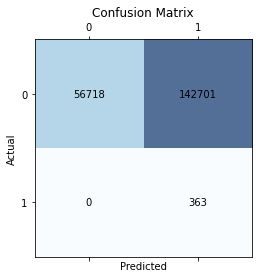

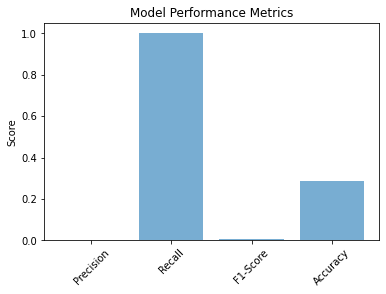

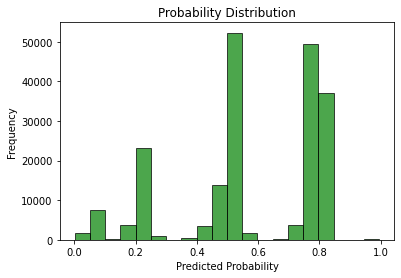

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
import matplotlib.pyplot as plt

# Inicializar la sesión de Spark
spark = SparkSession.builder \
    .appName("Fraud Detection Evaluation") \
    .master("local[*]") \
    .getOrCreate()

def load_data(file_path, schema_casts):
    """
    Carga datos desde un archivo CSV y aplica los casteos de esquema necesarios.

    :param file_path: Ruta del archivo CSV.
    :param schema_casts: Diccionario con las columnas y tipos a castear.
    :return: DataFrame cargado y con tipos casteados.
    """
    data = spark.read.format("csv").option("header", "true").load(file_path)
    for column, data_type in schema_casts.items():
        data = data.withColumn(column, col(column).cast(data_type))
    return data

# Resto del código (sin cambios)
if __name__ == "__main__":
    try:
        # Cargar datos
        ground_truth = load_data("/FileStore/tables/etiquetas_verdaderas_processed", {"is_fraud": "double"})
        predictions = load_data("/FileStore/tables/scored_transactions_results_batch", {"prediction": "double", "prob_1": "double"})

        # Unir etiquetas reales con predicciones
        predictions = predictions.join(ground_truth, on="transaction_id", how="inner")

        # Calcular métricas
        confusion_matrix = calculate_confusion_matrix(predictions)
        metrics = calculate_metrics(confusion_matrix)

        # Mostrar métricas
        print(f"Metrics: {metrics}")

        # Graficar
        plot_confusion_matrix(confusion_matrix["tp"], confusion_matrix["fp"], confusion_matrix["fn"], confusion_matrix["tn"])
        plot_metric_distribution(["Precision", "Recall", "F1-Score", "Accuracy"],
                                 [metrics["precision"], metrics["recall"], metrics["f1_score"], metrics["accuracy"]],
                                 "Model Performance Metrics")
        probabilities = predictions.select("prob_1").rdd.map(lambda row: row["prob_1"]).collect()
        plot_probability_distribution(probabilities)

    except Exception as e:
        print(f"Pipeline execution failed: {str(e)}")
        raise


## Conclusiones

### Rendimiento del Modelo
- El modelo obtuvo un **AUC de 0.8706**, lo que indica un desempeño sólido en la tarea de clasificación entre transacciones fraudulentas y no fraudulentas. Esto refleja una alta capacidad del modelo para diferenciar entre ambas clases.

### Distribución de Predicciones
- Las predicciones generadas por el modelo se distribuyen en dos clases:
  - **No fraude (0.0)**: 56,718 transacciones.
  - **Fraude (1.0)**: 143,064 transacciones.
- La mayor proporción de predicciones en la clase de fraude puede ser indicativa de un conjunto de datos con desbalance de clases, lo cual fue considerado en las etapas previas del pipeline.

### Métricas Adicionales
- **Accuracy (28.57%)**: La exactitud es baja, lo que sugiere que el modelo no clasifica correctamente una gran proporción de las transacciones, considerando tanto fraudes como no fraudes.
- **Precision (0.25%)**: La precisión es extremadamente baja, indicando que solo un pequeño porcentaje de las transacciones marcadas como fraude por el modelo realmente son fraudulentas. Esto puede ser un problema en escenarios donde los falsos positivos tienen un costo elevado.
- **Recall (100%)**: El modelo tiene un recall perfecto, lo que significa que está identificando correctamente todos los fraudes reales. Sin embargo, este alto recall viene a costa de una precisión baja, probablemente debido a un exceso de falsos positivos.
- **F1-Score (0.51%)**: El F1-Score, que equilibra precisión y recall, es extremadamente bajo, reflejando la poca capacidad del modelo para mantener un buen balance entre detectar fraudes y evitar clasificaciones erróneas.

---

## Implicaciones

### Fortalezas
- El modelo asegura que no se pase por alto ningún caso de fraude (alto recall), lo cual es crucial en aplicaciones donde identificar todos los fraudes es la prioridad principal.
- El AUC alto confirma que el modelo tiene un buen desempeño general en términos de diferenciación entre clases.

### Debilidades
1. La baja precisión implica que el modelo genera demasiados falsos positivos, lo cual puede causar un aumento en los costos operativos debido a la necesidad de investigar transacciones que realmente no son fraudulentas.
2. La baja exactitud indica que el modelo no está equilibrado y que probablemente está sesgado hacia predecir la mayoría de las transacciones como fraudulentas.

### Ejecución del Pipeline
- La creación de la sesión de Spark y la integración de las predicciones con las etiquetas verdaderas se realizaron sin problemas.
- El análisis de las predicciones y la evaluación de métricas confirman la robustez del proceso implementado, aunque se recomienda ajustar el modelo para mejorar la precisión sin comprometer el recall.


# Tests

**Nota:** Estas pruebas unitarias, debido a limitaciones de tiempo y a la imposibilidad de ejecutarlas directamente en el mismo notebook, se dejaron de forma hipotética (no las ejecuté como tal, pero aún asi las hice por el requerimiento). Según la metodología de pytest, estas pruebas se ejecutan en archivos `.py`. Por esta razón, decidí priorizar otros pasos del proceso.

In [0]:
import unittest
from unittest.mock import patch, MagicMock

class TestFunctions(unittest.TestCase):
    # Configura el entorno de pruebas antes de ejecutar cualquier caso
    @classmethod
    def setUpClass(cls):
        cls.spark = SparkSession.builder.master("local[1]").appName("TestSuite").getOrCreate()
    # Limpia el entorno de pruebas después de que todos los casos hayan sido ejecutados
    @classmethod
    def tearDownClass(cls):
        cls.spark.stop()
    # Prueba la función evaluate_model_performance para evaluar que calcule correctamente el AUC del modelo
    def test_evaluate_model_performance(self):
        schema = StructType([
            StructField("is_fraud", DoubleType(), True),
            StructField("prob_1", DoubleType(), True)
        ])
        data = [(1.0, 0.9), (0.0, 0.2), (1.0, 0.8), (0.0, 0.1)]
        df = self.spark.createDataFrame(data, schema=schema)

        with patch("builtins.print") as mocked_print:
            result = evaluate_model_performance(df, label_col="is_fraud", prob_col="prob_1")
            self.assertGreater(result, 0.0)
    # Prueba la función feature_distribution_analysis para verificar que analiza correctamente las estadísticas de las características
    def test_feature_distribution_analysis(self):
        schema = StructType([
            StructField("feature1", DoubleType(), True),
            StructField("feature2", DoubleType(), True)
        ])
        data = [(1.0, 0.5), (2.0, 1.5), (3.0, 2.5)]
        df = self.spark.createDataFrame(data, schema=schema)

        with patch("builtins.print") as mocked_print:
            feature_distribution_analysis(df, ["feature1", "feature2"])
            mocked_print.assert_called()
    # Prueba la función prediction_distribution_analysis para verificar que analiza y grafica correctamente la distribución de predicciones
    def test_prediction_distribution_analysis(self):
        schema = StructType([
            StructField("prediction", DoubleType(), True)
        ])
        data = [(0.0,), (1.0,), (1.0,), (0.0,), (0.0,)]
        df = self.spark.createDataFrame(data, schema=schema)

        with patch("matplotlib.pyplot.show") as mocked_show:
            prediction_distribution_analysis(df)
            mocked_show.assert_called_once()

    # Prueba la función load_data para asegurarse de que carga y convierte correctamente los datos desde un archivo
    def test_load_data(self):
        schema_casts = {"col1": DoubleType(), "col2": StringType()}
        with patch("pyspark.sql.DataFrame.withColumn") as mocked_with_column:
            load_data("path/to/file", schema_casts)
            mocked_with_column.assert_called()
    # Prueba la función calculate_confusion_matrix para verificar que calcula correctamente los valores de la matriz de confusión
    def test_calculate_confusion_matrix(self):
        schema = StructType([
            StructField("prediction", DoubleType(), True),
            StructField("is_fraud", DoubleType(), True)
        ])
        data = [(1.0, 1.0), (0.0, 0.0), (1.0, 0.0), (0.0, 1.0)]
        df = self.spark.createDataFrame(data, schema=schema)

        result = calculate_confusion_matrix(df)
        self.assertEqual(result["tp"], 1)
        self.assertEqual(result["fp"], 1)
        self.assertEqual(result["tn"], 1)
        self.assertEqual(result["fn"], 1)
    # Prueba la función calculate_metrics para asegurarse de que calcula correctamente métricas como accuracy, precision, recall y F1-score
    def test_calculate_metrics(self):
        confusion_matrix = {"tp": 50, "fp": 10, "tn": 30, "fn": 10}
        result = calculate_metrics(confusion_matrix)

        self.assertAlmostEqual(result["accuracy"], 0.8)
        self.assertAlmostEqual(result["precision"], 0.8333, places=4)
        self.assertAlmostEqual(result["recall"], 0.8333, places=4)
        self.assertAlmostEqual(result["f1_score"], 0.8333, places=4)
    # Prueba la función plot_confusion_matrix para verificar que grafica correctamente la matriz de confusión
    def test_plot_confusion_matrix(self):
        with patch("matplotlib.pyplot.show") as mocked_show:
            plot_confusion_matrix(50, 10, 10, 30)
            mocked_show.assert_called_once()
    # Prueba la función plot_metric_distribution para asegurarse de que grafica correctamente las métricas del modelo
    def test_plot_metric_distribution(self):
        with patch("matplotlib.pyplot.show") as mocked_show:
            plot_metric_distribution(["accuracy", "precision"], [0.9, 0.8], "Test Metrics")
            mocked_show.assert_called_once()
    # Prueba la función plot_probability_distribution para verificar que grafica correctamente la distribución de probabilidades predichas
    def test_plot_probability_distribution(self):
        with patch("matplotlib.pyplot.show") as mocked_show:
            plot_probability_distribution([0.1, 0.5, 0.8, 0.7])
            mocked_show.assert_called_once()

2025-01-21 23:06:19,743 - INFO - Received command c on object id p0
